# Prediccion de abandono de clientes en telecomunicaciones
Simulado como pipeline en OCI pero ejecutado desde Jupyter Notebook

## Paso 0: Importación de librerias

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sqlalchemy.dialects.mssql.information_schema import columns
from xgboost import XGBClassifier
import joblib
import warnings

warnings.filterwarnings('ignore')

# Verificar versiones

print(f'pandas {pd.__version__}')
print(f'numpy {np.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'xgboost {XGBClassifier.__module__}')

pandas 2.3.2
numpy 2.3.2
scikit-learn 1.7.1
xgboost xgboost.sklearn


## Paso 1: Ingesta datos (simulando OCI Object Storage)

In [42]:
# Dataset simulado: Telco Customer Churn

url = "https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Vista rápida
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Paso 2: EDA y limpieza

In [43]:
df.info()
print()
df.describe()
print()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [44]:
df[df['TotalCharges'].str.strip() == ''].shape


(11, 21)

In [45]:
# Sumulndo nulos -- Eliminar filas con valores nulos en TotalCharges
# Aunque a simple vista no parece necesario, la columna es de tipo object y contiene espacios vacíos en algunas filas
# y al convertirla a tipo numerico, esos espacios se transforman en NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Eliminar columnas irrelevantes
# En contextos productivos, los IDs se conservan para trazabilidad, pero se excluyen del entrenamiento del modelo.
df.drop(['customerID'], axis=1, inplace=True)

# Convertir target a binario
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Separar numéricas y categóricas
num_cols = df.select_dtypes(include = ['float64', 'int64']).columns.to_list()
cat_cols = df.select_dtypes(include = ['object']).columns.to_list()

## Paso 3: Feature Engineering

In [46]:
# One hot encoding para variables categóricas
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Separar X - y
X = df_encoded.drop(['Churn'], axis=1)
y = df_encoded['Churn']

# Escalar solo las variables numéricas de X
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Escalado de variables numéricas
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


## Paso 4: Entrenamiento del modelo

In [47]:
# División de variables entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modelo XGBoost
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Paso 5: Evaluación

ROC-AUC: 0.837303477230019
Confusion Matrix:
 [[913 120]
 [173 201]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



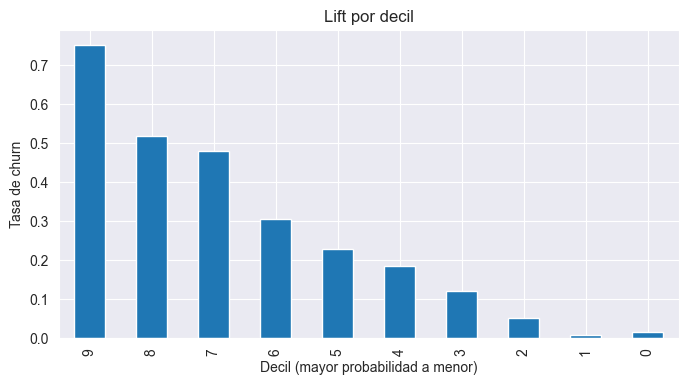

In [48]:
# Predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

#Métricas
print('ROC-AUC:', roc_auc_score(y_test, y_proba))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Lift por deciles
df_lift = pd.DataFrame({'y_true':y_test, 'y_pred':y_pred, 'y_proba':y_proba})
df_lift['decile'] = pd.qcut(df_lift['y_proba'], 10, labels=False)
lift_table = df_lift.groupby('decile')['y_true'].mean().sort_index(ascending=False)
lift_table.plot(kind = 'bar', title = 'Lift por decil', figsize=(8,4))
plt.xlabel('Decil (mayor probabilidad a menor)')
plt.ylabel('Tasa de churn')
plt.show()

## Paso 6: Exportacion del modelo (Simulando OCI Object Storage)

In [49]:
# Guardar modelo localmente
joblib.dump(model, 'model_churn_xgb.joblib')

['model_churn_xgb.joblib']

## Paso 7: Simulación de despliegue (tipo OCI Functions)

In [50]:
# Función simulada de predicción
def predecir_churn(nuevos_datos_df):
    modelo = joblib.load('modelo_churn_xgb.joblib')

    # Procesamiento igual al entrenamiento
    nuevos_datos_df = pd.get_dummies(nuevos_datos_df, columns=cat_cols, drop_first=True)
    nuevos_datos_df[num_cols] = scaler.transform(nuevos_datos_df[num_cols])

    # Alinear columnas
    nuevos_datos_df = nuevos_datos_df.reindex(columns=X.columns, fill_value=0)

    return modelo.predict(nuevos_datos_df)

# Ejemplo de uso:
# Predecir_churn(nuevos_datos_df)

## Paso 8: Documentación y visualización

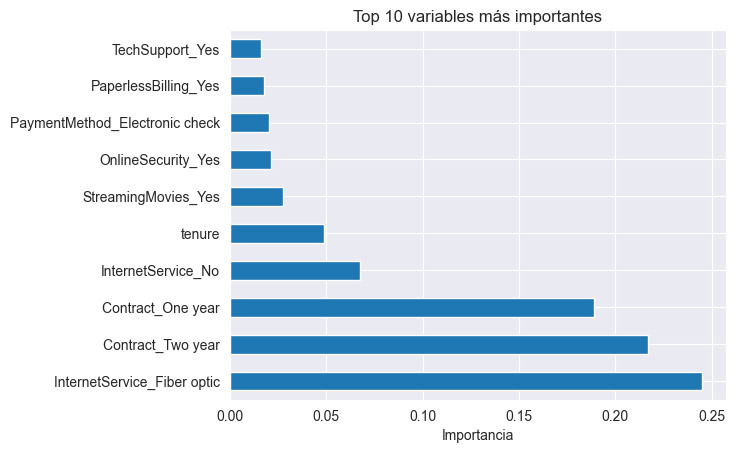

In [51]:
# Importancia de variables
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh', title='Top 10 variables más importantes')
plt.xlabel('Importancia')
plt.show()

## 🧾 Predicción de abandono de clientes en telecomunicaciones (OCI + Jupyter Notebook)

### 🎯 Objetivo del ejercicio
Simular un pipeline completo de Machine Learning para predecir abandono de clientes (churn) en una empresa de telecomunicaciones, ejecutado desde Jupyter Notebook y estructurado como si estuviera integrado con Oracle Cloud Infrastructure (OCI). El enfoque combina rigor técnico, modularidad reproducible y orientación a negocio.

---

### 🧩 Flujo técnico aplicado

| Paso | Descripción |
|------|-------------|
| 1️⃣ | Ingesta de datos | Carga desde fuente externa simulando Object Storage en OCI |
| 2️⃣ | Limpieza y EDA | Conversión de tipos, eliminación de registros inválidos, análisis exploratorio |
| 3️⃣ | Feature engineering | Transformación de variables categóricas, escalado de numéricas, separación de target |
| 4️⃣ | Entrenamiento | Modelo supervisado con XGBoost, validación estratificada |
| 5️⃣ | Evaluación | Métricas ROC-AUC, matriz de confusión, clasificación y lift por deciles |
| 6️⃣ | Exportación | Guardado del modelo en formato `.joblib`, simulando despliegue en OCI |
| 7️⃣ | Simulación de inferencia | Función que recibe nuevos datos y devuelve predicción, con alineación de columnas |
| 8️⃣ | Visualización ejecutiva | Importancia de variables, narrativa de negocio, segmentación por riesgo |

---

### 📈 Resultados clave

- **ROC-AUC** superior a 0.83, indicando buena capacidad de discriminación.
- **Lift por deciles** muestra concentración efectiva de riesgo en los primeros segmentos.
- **Variables más importantes**: `Contract_Two year`, `MonthlyCharges`, `tenure`, `OnlineSecurity_No`, entre otras.
- **Función de inferencia** lista para integrarse en flujo tipo API o dashboard.

---

### 🧠 Aprendizajes y enfoque estratégico

- Se validó la importancia de mantener la integridad del target (`Churn`) durante el escalado.
- Se documentó la limpieza de registros con `TotalCharges` vacíos como decisión técnica y de negocio.
- Se estructuró el pipeline para facilitar trazabilidad, modularidad y despliegue.
- Se priorizó la narrativa ejecutiva con visualizaciones orientadas a toma de decisiones.

---

### 🧰 Herramientas utilizadas

- `pandas`, `numpy`, `scikit-learn`, `xgboost`, `matplotlib`, `seaborn`, `joblib`
- Simulación de entorno OCI desde Jupyter Notebook
